# Evaluation Metrics

### GPU Configurations

In [1]:
import os                                        # Operating system-related functions (file, directory operations)
import sys                                       # Provides access to system-specific parameters and functions
import platform                                  # Provides functions and information about the operating system and hardware
import warnings                                  # Suppress warnings

import numpy as np                               # numerical operations & array manipulation
import pickle                                    # for object serialization & deserialization
import random                                    # generates random numbers
import math

import cv2                                       # computer vision & image processing
import tensorflow as tf                          # deep learning framework
import keras                                     # training & evaluating deep learning models
import itertools                                 # combinations & permutations

from skimage.io import imread                    # reading images
from skimage.io import imshow                    # displaying images
from tqdm import tqdm                            # creating progress bars in loops
from typing import Dict                          # type hinting
from typing import List                          # type hinting
from typing import Tuple                         # type hinting
from typing import Optional                      # type hinting
import matplotlib.pyplot as plt                  # creating plots & visualizations


import networkx as nx                            # graph-based data structures & algorithms
from skimage.morphology import skeletonize       # image skeletonization
from skimage.measure import label                # connected component labeling
from skimage.draw import line                    # drawing straight lines in images

In [2]:
# Check Operating System & Platform
print('Operating System:', platform.system(), platform.release())
print('Python Platform:', platform.platform())

# Check Python Version
print('Python Version:', sys.version)
print()

# Print library versions
print('NumPy Version:', np.__version__)
print('OpenCV Version:', cv2.__version__)
print('TensorFlow Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print()

# Check if any GPU is available
print('GPU is Available:', len(tf.config.list_physical_devices('GPU')) > 0)
print('Number of GPUs Available:', len(tf.config.list_physical_devices('GPU')))

Operating System: Darwin 23.2.0
Python Platform: macOS-14.2.1-arm64-arm-64bit
Python Version: 3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]

NumPy Version: 1.24.3
OpenCV Version: 4.8.0
TensorFlow Version: 2.13.0
Keras Version: 2.13.1

GPU is Available: True
Number of GPUs Available: 1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory limit for the first GPU to 0.31
        gpu_memory_limit = 0.30
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(gpu_memory_limit * 1024))]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Memory limit must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-29 10:20:43.613830: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-29 10:20:43.613848: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-29 10:20:43.613853: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-29 10:20:43.613918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 10:20:43.613955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Metrics

High Similarity: If betweenness_centrality_difference is low (close to 0), it indicates that the betweenness centralities of nodes in the proposal graph (G') are similar to those in the ground truth graph (G). This suggests that the nodes in G' are positioned in a way that paths through these nodes are similar to those in G. In this case, the two graphs are structurally similar, and the APLS similarity score for the pair of nodes is high.

Low Similarity: If betweenness_centrality_difference is high, it means that the betweenness centralities of corresponding nodes in G' are significantly different from those in G. This suggests that the structure of G' is significantly different from G in terms of how central nodes are for path traversal. In this case, the APLS similarity score for the pair of nodes is low.

In summary, the betweenness_centrality_difference serves as a structural similarity measure by quantifying how similar or different the central nodes are in the two graphs. The APLS metric uses this measure, along with other factors such as path length differences, to compute an overall similarity score that reflects how closely the structure of the proposal graph matches the ground truth graph.



In [4]:
# Point Type (coordinates)
Point = Tuple[float, float]

def euclidean_distance(point1: Tuple[float, float], point2: Tuple[float, float]) -> float:
    '''
    Calculate Euclidean distance between two points represented as tuples (x, y).
    
    Args:
        point1 (Tuple[float, float]): 1st point as a tuple (x, y).
        point2 (Tuple[float, float]): 2nd point as a tuple (x, y).
    
    Returns:
        float: The Euclidean distance between the two points.
    '''
    node1 = np.array(point1)
    node2 = np.array(point2)
    distance = np.linalg.norm(node1 - node2)
    return distance


def find_nearest_node(graph: nx.Graph, point: Tuple[int, int], pixel_resolution: int = 50, max_distance: float = 10) -> Optional[int]:
    '''
    Find the nearest node in the graph to a given point.

    Args:
        graph (nx.Graph): The networkx graph.
        point (Tuple[float, float]): The coordinates of the input point (x, y).
        max_distance (float): The maximum distance to consider in metres. Defaults to positive infinity.
        pixel_resolution (int): Pixel resolution value in centimetres/pixel. Defaults to 50.

    Returns:
        Optional[float]: The nearest node in the graph, or None if no node is found within the maximum distance.
    '''
    nearest_node = None

    # Convert maximum distance to centimeters since pixel_resolution is in centimeters/pixel
    maximum_pixel_distance = max_distance * 100 / pixel_resolution
    
    for node in graph.nodes:
        pixel_distance = euclidean_distance(point, node)
        if pixel_distance < maximum_pixel_distance:
            nearest_node = node
            maximum_pixel_distance = pixel_distance
    return nearest_node

### Average Path Length Similarity (APLS) Metric

The APLS (Average Path Length Similarity) metric is a measure used to assess the similarity between two graphs, typically a ground truth graph and a predicted graph. In the context of road network analysis, the APLS metric is employed to evaluate how well the predicted road network matches the ground truth road network. The metric involves classifying nodes in the road network into terminal nodes and intersection nodes, where terminal nodes have only one neighbor and intersection nodes have more than two neighbors.

The APLS metric is then calculated based on the comparison of shortest paths between terminal nodes in the ground truth graph and their corresponding nearest nodes in the predicted graph. The formula for APLS is given by: C = 1 - 1 / N Σ min{1, | L(a,b) - L(a',b') | / L(a,b)}


Here, N represents the number of shortest paths,  L(a,b) is the path distance in the ground truth graph, L(a′,b′) is the path length between corresponding nodes in the predicted graph, and the maximum difference is the maximum proportional difference allowed between paths. The APLS score ranges from 0 to 1, where a higher score indicates a greater similarity between the ground truth and predicted graphs. The metric takes into account the lengths of corresponding paths and penalizes discrepancies in path lengths proportional to the length of the ground truth path.

In [5]:
# Classify nodes to terminal or intersection points
def classify_road_segments(graph: nx.Graph) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
    '''
    Classify nodes in a road network graph into terminal nodes, intersection nodes, and line segments.

    Args:
        graph (nx.Graph): The road network graph.

    Returns:
        Tuple[List[Tuple[int, int]], List[Tuple[int, int]], List[List[Tuple[int, int]]]]:
            - terminal_nodes: List of terminal node coordinates (x, y).
            - intersection_nodes: List of intersection node coordinates (x, y).
    '''

    terminal_nodes = []
    intersection_nodes = []

    # Post-Processing:
    nodes_to_remove = set()  # Use a set to store nodes to remove
    edges_to_add = []        # List to store edges to add

    intermediate_nodes = set()
    nodes = list(graph.nodes())

    for node in nodes:
        neighbors = list(graph.neighbors(node))

        if len(neighbors) == 1:
            terminal_nodes.append(node)

        elif len(neighbors) > 2:
            intersection_nodes.append(node)

    return terminal_nodes, intersection_nodes


# Compute APLS metric
def apls(
    ground_truth_graph: nx.Graph,
    predicted_graph: nx.Graph,
    max_difference: int = 1,
) -> float:
    '''
    Calculate the APLS metric

    Parameters:
        ground_truth_graph (nx.Graph): The ground truth graph.
        predicted_graph (nx.Graph): The predicted graph.
        max_difference (int): Maximum difference allowed in the APLS metric. Defaults to 1.
    Returns:
        float: APLS score.

    The APLS metric is calculated based on the formula:
    C = 1 - 1 / N Σ min{1, | L(a,b) - L(a',b') | / L(a,b)}

    Where:
        - N is the number of shortest paths.
        - Node a' is the node in the predicted graph nearest to node a in the ground truth graph.
        - Node b' is the node in the predicted graph nearest to node b in the ground truth graph.
        - L(a, b) denotes a path distance in the ground truth graph.
        - L(a', b') denotes the path length between corresponding nodes in the predicted graph.
        - Max difference is the maximum proportional difference between paths.
    '''

    N = 0
    total_difference = 0

     # Filter terminal nodes for the ground truth graph
    terminal_nodes, intersection_node = classify_road_segments(ground_truth_graph)
    
    for node_a, node_b in itertools.combinations(terminal_nodes, 2):
        if node_a != node_b:
            # Find the corresponding nodes in the predicted graph a' and b'
            node_a_prime = find_nearest_node(predicted_graph, node_a)
            node_b_prime = find_nearest_node(predicted_graph, node_b)

            # Skip if no corresponding nodes ==> no proper path
            if node_a_prime is None or node_b_prime is None:
                N += 1
                total_difference += max_difference
                continue

            # Find the path length, L(a,b) in the ground truth graph
            try:
                shortest_path = nx.shortest_path(ground_truth_graph, node_a, node_b)
                L_a_b = sum(euclidean_distance(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path) - 1))
            except (nx.NetworkXNoPath, KeyError):
                L_a_b = None

            # Find the path length, L(a',b') in the predicted graph
            try:
                shortest_path = nx.shortest_path(predicted_graph, source=node_a_prime, target=node_b_prime)
                L_a_prime_b_prime = sum(euclidean_distance(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path) - 1))
            except (nx.NetworkXNoPath, KeyError):
                L_a_prime_b_prime = None

            # Handle the case when there are no paths
            if L_a_b is not None and L_a_prime_b_prime is not None:
                proportional_difference = abs(L_a_b - L_a_prime_b_prime) / L_a_b
                difference = min(max_difference, proportional_difference)
            elif L_a_b is None and L_a_prime_b_prime is None:
                continue
            else:
                difference = max_difference
                
            # Increment
            N += 1
            total_difference += difference

    # Calculate APLS score
    apls = 1 - total_difference / N if N > 0 else 0
    apls = round(apls, 4)

    return apls

### Topology (TOPO) Metric

The TOPO (Topology-Oriented) metric is a measure used to evaluate the topological similarity between two graphs, typically a ground truth graph and a predicted graph. In the context of road network analysis, the TOPO metric is employed to assess how well the predicted road network matches the ground truth road network based on the orientation of edges between corresponding nodes.

The calculation involves several components:

1. Angle Relative to X-Axis Calculation:
The angle_relative_to_x_axis function computes the angle of an edge relative to the x-axis. This angle is crucial for determining the orientation of edges in both graphs.

2. Edges Orientation Checking:
The check_edges_orientation function compares the orientation of edges between a node in the ground truth graph and its nearest corresponding node in the predicted graph. It considers the angle differences between corresponding edges, and if the angles exceed a specified threshold (min_angle), it returns False, indicating a mismatch in orientation.

3. TOPO Metric Computation:
The TOPO function computes the TOPO metric, including precision, recall, and F1 score. It iterates through nodes in both the ground truth and predicted graphs, finding nearest corresponding nodes and checking edges orientation. True positives (TP) are counted when the orientations match, false positives (FP) occur when edges are wrongly oriented in the predicted graph, and false negatives (FN) occur when the predicted graph does not have a corresponding node or has incorrectly oriented edges.

The precision, recall, and F1 score are then calculated using standard formulas:​

* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)
* F1 = 2 * (Precision * Recall) / (Precision + Recall)

These metrics provide a quantitative assessment of the topological similarity between the ground truth and predicted graphs, taking into account both correctly and incorrectly oriented edges. The resulting values range from 0 to 1, with higher scores indicating a better topological match between the two graphs.

In [6]:
# Calculate the angle of an edge relative to the x-axis
def angle_relative_to_x_axis(edge_coords: Tuple[Point, Point]) -> float:
    '''
    Calculates the angle of an edge relative to the x-axis.

    Args:
        edge_coords (Tuple[Point, Point]): Tuple of edge coordinates.

    Returns:
        float: Angle of the edge relative to the x-axis.
    '''
    delta_x = edge_coords[1][0] - edge_coords[0][0]
    delta_y = edge_coords[1][1] - edge_coords[0][1]

    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    angle_degrees_positive = angle_degrees % 360

    return round(angle_degrees_positive, 2)

# Check edges orientation between two graphs at specific nodes
def check_edges_orientation(graph_A: nx.Graph, graph_B: nx.Graph, node_A: int, nearest_node_B: Optional[int], min_angle: float = 10) -> bool:
    '''
    Checks the orientation of edges between two graphs at specific nodes.

    Args:
        graph_A (nx.Graph): Networkx graph as reference.
        graph_B (nx.Graph): Networkx graph for comparison.
        node_A (int): Node in graph A.
        nearest_node_B (Optional[int]): Nearest node in graph B to node_A.
        min_angle (float): Minimum acceptable angle difference. Defaults to 10.

    Returns:
        bool: True if edges' orientations are within the specified angle, False otherwise.
    '''
    edges_A = list(graph_A.edges(node_A))
    edges_B = list(graph_B.edges(nearest_node_B)) if nearest_node_B is not None else []

    if len(edges_A) == len(edges_B):
        for edge_A, edge_B in zip(edges_A, edges_B):
            angle_A = angle_relative_to_x_axis(edge_A)
            angle_B = angle_relative_to_x_axis(edge_B)

            if not abs(angle_A - angle_B) <= min_angle:
                return False
    else:
        return False

    return True

# Compute TOPO metric
def TOPO(ground_truth_graph: nx.Graph, predicted_graph: nx.Graph) -> Tuple[float, float, float]:
    '''
    Computes the TOPO metric, including precision, recall, and F1 score.

    Parameters:
        ground_truth_graph (Graph): The ground truth graph.
        predicted_graph (Graph): The predicted graph.

    Returns:
        Tuple[float, float, float]: Precision, recall, and F1 score.
    '''
    TP = 0 # true positives
    FP = 0 # false positives
    FN = 0 # false negatives

    # Iterating through nodes in the ground truth graph
    for node in ground_truth_graph.nodes():
        nearest_node = find_nearest_node(predicted_graph, node)

        if nearest_node is not None:
            if check_edges_orientation(ground_truth_graph, predicted_graph, node, nearest_node):
                TP += 1
            else:
                FN += 1
        else:
            FN += 1

    # Iterating through nodes in the predicted graph
    for node in predicted_graph.nodes():
        nearest_node = find_nearest_node(ground_truth_graph, node)

        if nearest_node is not None:
            if not check_edges_orientation(predicted_graph, ground_truth_graph, node, nearest_node):
                FP += 1
        else:
            FP += 1

    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precision = round(precision, 4)
    recall = round(recall, 4)
    f1 = round(f1, 4)

    return precision, recall, f1

In [7]:
# Define the start and end coordinates
start = (0, 0)
end = (10, 0)

# Create a bounding box
G_box = nx.Graph()
G_box.add_nodes_from([(0, 0), (0, -5), (10, 0), (10, 5)])
pos = {node: node for node in G_box.nodes()}

# Create the straight line graph
mid1 = (3, 0)
mid2 = (7, 0)
G_line = nx.Graph()
G_line.add_node(start, pos=start)
G_line.add_node(mid1, pos=mid1)
G_line.add_node(mid2, pos=mid2)
G_line.add_node(end, pos=end)
G_line.add_edges_from([(start, mid1), (mid1, mid2), (mid2, end)])
path_length_line = math.dist(start, mid1) + math.dist(mid1, mid2) + math.dist(mid2, end)

# Create the zigzag graph 1
mid3 = (3, 2)
mid4 = (7, 0)
G_zigzag_1 = nx.Graph()
G_zigzag_1.add_nodes_from([(start, {'pos': start}), (mid3, {'pos': mid3}), (mid4, {'pos': mid4}), (end, {'pos': end})])
G_zigzag_1.add_edges_from([(start, mid3), (mid3, mid4), (mid4, end)])
path_length_zigzag_1 = math.dist(start, mid3) + math.dist(mid3, mid4) + math.dist(mid4, end)

# Create the zigzag graph 2
mid3 = (3, 2)
mid4 = (7, -2)
end_zigzag = (10, 0)
G_zigzag_2 = nx.Graph()
G_zigzag_2.add_nodes_from([(start, {'pos': start}), (mid3, {'pos': mid3}), (mid4, {'pos': mid4}), (end_zigzag, {'pos': end_zigzag})])
G_zigzag_2.add_edges_from([(start, mid3), (mid3, mid4), (mid4, end_zigzag)])
path_length_zigzag_2 = math.dist(start, mid3) + math.dist(mid3, mid4) + math.dist(mid4, end)

# Calculate APLS score
similarity_score_1 = apls(G_line, G_zigzag_1)
similarity_score_2 = apls(G_line, G_zigzag_2)
similarity_score_3 = apls(G_zigzag_1, G_zigzag_2)

# Calculate TOPO scores
precision_1, recall_1, f1_1 = TOPO(G_line, G_zigzag_1)
precision_2, recall_2, f1_2 = TOPO(G_line, G_zigzag_2)
precision_3, recall_3, f1_3 = TOPO(G_zigzag_1, G_zigzag_2)

# Print scores
print('Straight Line vs Zigzag 1')
print('APLS Score:', round(similarity_score_1, 3))
print('TOPO Precision:', precision_1)
print('TOPO Recall:', recall_1)
print('TOPO F1:', f1_1)
print()
print('Straight Line vs Zigzag 2')
print('APLS Score:', round(similarity_score_2, 3))
print('TOPO Precision:', precision_2)
print('TOPO Recall:', recall_2)
print('TOPO F1:', f1_2)

print('Zigzag 1 vs Zigzag 2')
print('APLS Score:', round(similarity_score_3, 3))
print('TOPO Precision:', precision_3)
print('TOPO Recall:', recall_3)
print('TOPO F1:', f1_3)

Straight Line vs Zigzag 1
APLS Score: 0.892
TOPO Precision: 0.25
TOPO Recall: 0.25
TOPO F1: 0.25

Straight Line vs Zigzag 2
APLS Score: 0.713
TOPO Precision: 0.0
TOPO Recall: 0.0
TOPO F1: 0
Zigzag 1 vs Zigzag 2
APLS Score: 0.838
TOPO Precision: 0.25
TOPO Recall: 0.25
TOPO F1: 0.25


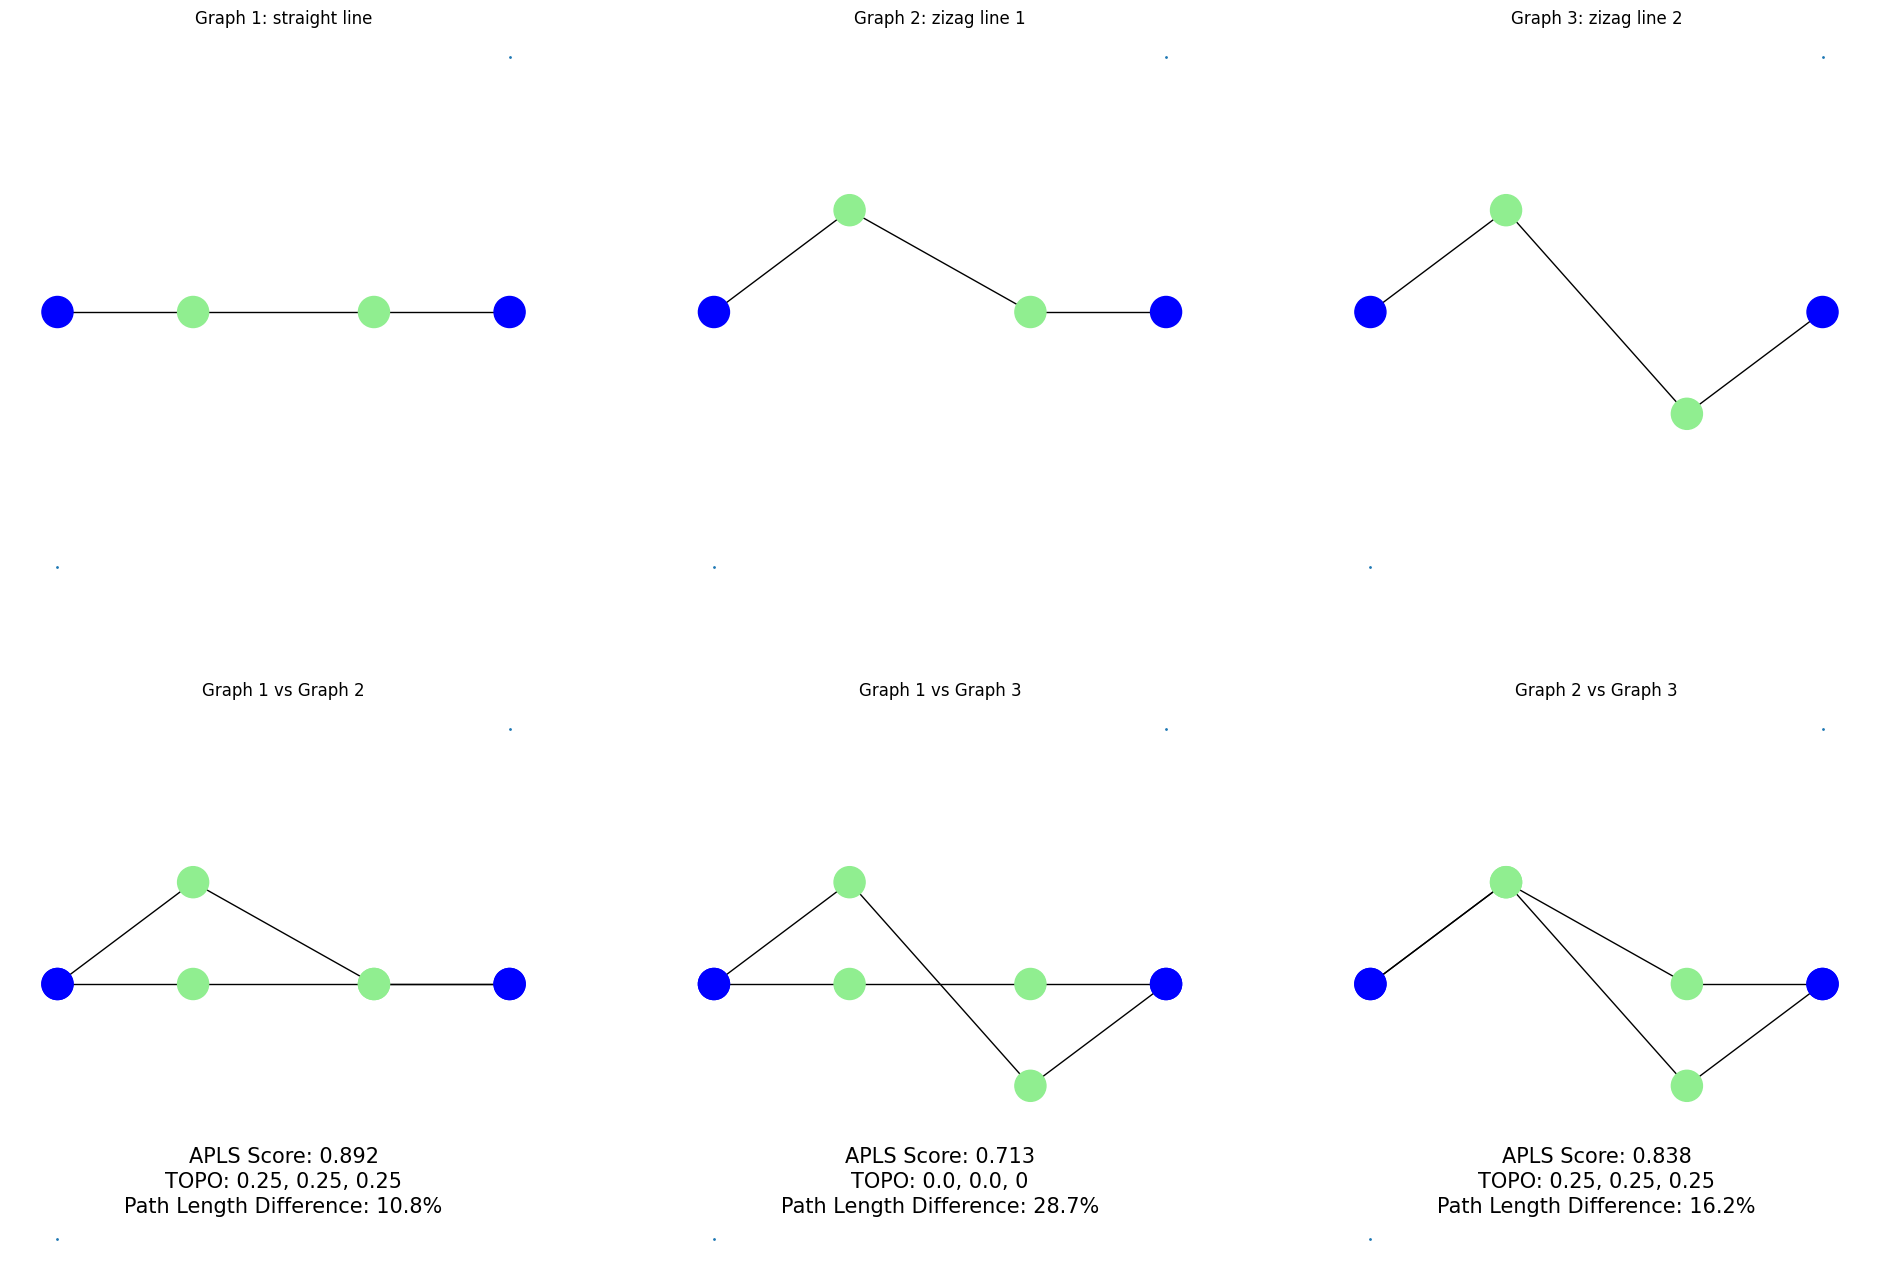

In [8]:
# Create a figure with three subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

# Draw the bounding box on the subplots
nx.draw(G_box, pos=pos, node_size=1, ax=axes[0,0])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[0,1])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[0,2])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[1,0])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[1,1])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[1,2])

# Get positions for drawing the graphs
pos_line = nx.get_node_attributes(G_line, 'pos')
pos_zigzag_1 = nx.get_node_attributes(G_zigzag_1, 'pos')
pos_zigzag_2 = nx.get_node_attributes(G_zigzag_2, 'pos')

# Plot the straight line graph on the first subplot
axes[0,0].set_title('Graph 1: straight line')
nx.draw(G_line, pos=pos_line, with_labels=False, node_size=500, ax=axes[0,0], node_color=['lightgreen' if node not in (start, end) else 'blue' for node in G_line.nodes()], font_weight='bold')

# Plot the zigzag graph 1 on the second subplot
axes[0,1].set_title('Graph 2: zizag line 1')
nx.draw(G_zigzag_1, pos=pos_zigzag_1, with_labels=False, node_size=500, ax=axes[0,1], node_color=['lightgreen' if node != start and node != end else 'blue' for node in G_zigzag_1.nodes()], font_weight='bold')

# Plot the zigzag graph 2 on the third subplot
axes[0,2].set_title('Graph 3: zizag line 2')
nx.draw(G_zigzag_2, pos=pos_zigzag_2, with_labels=False, node_size=500, ax=axes[0,2], node_color=['lightgreen' if node != start and node != end else 'blue' for node in G_zigzag_2.nodes()], font_weight='bold')

# Plot comparison 1 on the fourth subplot
apls_score_text_1 = f'APLS Score: {similarity_score_1:.3f}'
topo_score_text_1 = f'TOPO: {precision_1}, {recall_1}, {f1_1}'
text_1 = f'Path Length Difference: {(abs(path_length_zigzag_1 - path_length_line)/path_length_line)  * 100:.1f}%'
axes[1,0].set_title('Graph 1 vs Graph 2')
axes[1,0].text(5, -3.5, apls_score_text_1, ha='center', fontsize=15)
axes[1,0].text(5, -4.0, topo_score_text_1, ha='center', fontsize=15)
axes[1,0].text(5, -4.5,            text_1, ha='center', fontsize=15)
nx.draw(G_zigzag_1, pos=pos_zigzag_1, with_labels=False, node_size=500, ax=axes[1,0], node_color=['lightgreen' if node != start and node != end else 'blue' for node in G_zigzag_1.nodes()], font_weight='bold')
nx.draw(G_line, pos=pos_line, with_labels=False, node_size=500, ax=axes[1,0], node_color=['lightgreen' if node not in (start, end) else 'blue' for node in G_line.nodes()], font_weight='bold')

# Plot comparison 2 on the fifth subplot
apls_score_text_2 = f'APLS Score: {similarity_score_2:.3f}'
topo_score_text_2 = f'TOPO: {precision_2}, {recall_2}, {f1_2}'
text_2 = f'Path Length Difference: {(abs(path_length_zigzag_2 - path_length_line)/path_length_line)  * 100:.1f}%'
axes[1,1].set_title('Graph 1 vs Graph 3')
axes[1,1].text(5, -3.5, apls_score_text_2, ha='center', fontsize=15)
axes[1,1].text(5, -4.0, topo_score_text_2, ha='center', fontsize=15)
axes[1,1].text(5, -4.5,            text_2, ha='center', fontsize=15)
nx.draw(G_zigzag_2, pos=pos_zigzag_2, with_labels=False, node_size=500, ax=axes[1,1], node_color=['lightgreen' if node != start and node != end else 'blue' for node in G_zigzag_2.nodes()], font_weight='bold')
nx.draw(G_line, pos=pos_line, with_labels=False, node_size=500, ax=axes[1,1], node_color=['lightgreen' if node not in (start, end) else 'blue' for node in G_line.nodes()], font_weight='bold')

# Plot comparison 2 on the fifth subplot
apls_score_text_3 = f'APLS Score: {similarity_score_3:.3f}'
topo_score_text_3 = f'TOPO: {precision_3}, {recall_3}, {f1_3}'
text_3 = f'Path Length Difference: {(abs(path_length_zigzag_2 - path_length_zigzag_1)/path_length_zigzag_1)  * 100:.1f}%'
axes[1,2].set_title('Graph 2 vs Graph 3')
axes[1,2].text(5, -3.5, apls_score_text_3, ha='center', fontsize=15)
axes[1,2].text(5, -4.0, topo_score_text_3, ha='center', fontsize=15)
axes[1,2].text(5, -4.5,            text_3, ha='center', fontsize=15)
nx.draw(G_zigzag_1, pos=pos_zigzag_1, with_labels=False, node_size=500, ax=axes[1,2], node_color=['lightgreen' if node != start and node != end else 'blue' for node in G_zigzag_1.nodes()], font_weight='bold')
nx.draw(G_zigzag_2, pos=pos_zigzag_2, with_labels=False, node_size=500, ax=axes[1,2], node_color=['lightgreen' if node != start and node != end else 'blue' for node in G_zigzag_2.nodes()], font_weight='bold')


In the 1st loop, we are iterating through nodes in the ground truth graph.

* For each node, we find the nearest node in the predicted graph.
* If there is a nearest node, we check the orientation of edges between them.
* If the orientation is correct, we count it as a true positive (TP), otherwise, we count it as a false negative (FN).

In the 2nd loop, we are iterating through nodes in the predicted graph.
* For each node, we find the nearest node in the ground truth graph.
* If there is a nearest node, we check the orientation of edges between them.
* If the orientation is incorrect, we count it as a false positive (FP).



In the context of graphs, a false positive means that a node or an edge is present in the predicted graph but should not be there according to the ground truth.

In the context of graphs, a false negative means that a node or an edge is missing in the predicted graph but should be present according to the ground truth.

Precision
* TP=4 (nodes 1, 2, 3, and 4 in the ground truth graph have correct orientation in the predicted graph).
* FP=1 (node 5 in the predicted graph is a false positive).
* $P = \frac{4}{4 + 1} = \frac{4}{5} = 0.8$

Recall
* TP=4 (nodes 1, 2, 3, and 4 in the ground truth graph have correct orientation in the predicted graph).
* FN=0 (no false negatives, all correct orientations are captured in the predicted graph).
* $R = \frac{4}{4 + 0} = \frac{4}{4} = 1.0$

F1 Score
* The F1 score is the harmonic mean of precision and recall.
* $F1 = \frac{2 * 0.8 * 1.0}{1.8 + 1.0} = \frac{1.6}{1.8} = 0.8889$


In summary, the values (0.8, 1.0, 0.8889) indicate that the predicted graph has a high precision (80%), meaning that the majority of identified orientations are correct. The recall is perfect (100%), indicating that all correct orientations in the ground truth graph are captured by the predicted graph. The F1 score provides a balanced measure of precision and recall, yielding a value of approximately 0.8889. This suggests that the predicted graph is performing well in terms of both precision and recall.

(0.8, 1.0, 0.8889)


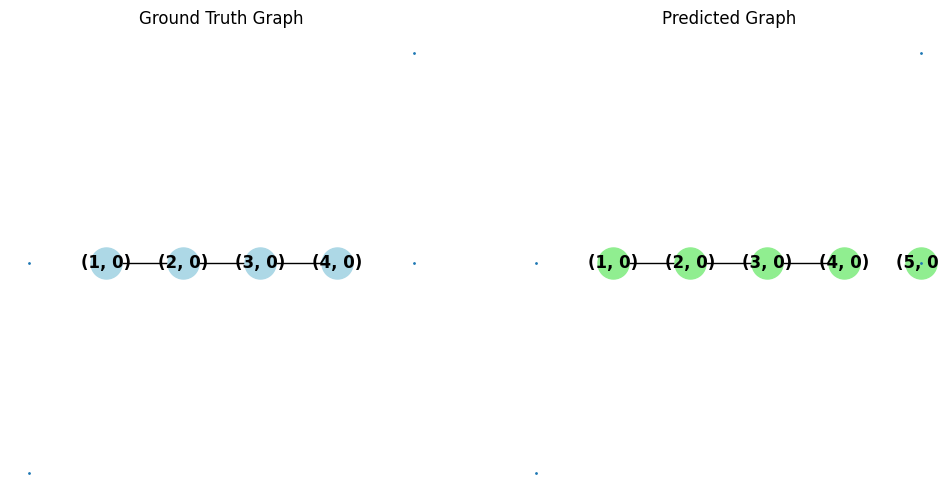

In [9]:
# Ground Truth Graph
ground_truth_graph = nx.Graph()
ground_truth_graph.add_nodes_from([(1, 0), (2, 0), (3, 0), (4, 0)])
ground_truth_graph.add_edges_from([((1, 0), (2, 0)), ((2, 0), (3, 0)), ((3, 0), (4, 0))])

# Predicted Graph with a False Positive
predicted_graph = nx.Graph()
predicted_graph.add_nodes_from([(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)])               # Additional node (false positive +1)
predicted_graph.add_edges_from([((1, 0), (2, 0)), ((2, 0), (3, 0)), ((3, 0), (4, 0))])

print(TOPO(ground_truth_graph, predicted_graph))

# Create a bounding box
G_box = nx.Graph()
G_box.add_nodes_from([(0, 0), (0, -5), (5, 0), (5, 5)])
pos = {node: node for node in G_box.nodes()}

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Ground Truth Graph
pos_ground_truth = {node: node for node in ground_truth_graph.nodes()}
nx.draw(ground_truth_graph, pos=pos_ground_truth, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold', ax=axes[0])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[0])
axes[0].set_title('Ground Truth Graph')

# Plot Predicted Graph
pos_predicted = {node: node for node in predicted_graph.nodes()}
nx.draw(predicted_graph, pos=pos_predicted, with_labels=True, node_size=500, node_color='lightgreen', font_weight='bold', ax=axes[1])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[1])
axes[1].set_title('Predicted Graph')

plt.show()

Precision
* TP=3 (nodes 1, 2, and 3 in the ground truth graph have correct orientation in the predicted graph).
* FP=1 (node 5 in the predicted graph is a false positive).
* $P = \frac{3}{3 + 1} = \frac{3}{4} = 0.75$

Recall
* TP=3 (nodes 1, 2, and 3 in the ground truth graph have correct orientation in the predicted graph).
* FN=1 (node 4 in the ground truth graph has incorrect orientation).
* $R = \frac{3}{3 + 1} = \frac{3}{4} = 0.75$

F1 Score
* The F1 score is the harmonic mean of precision and recall.
* $F1 = \frac{2 * 0.75 * 0.75}{0.75 + 0.75} = \frac{1.125}{1.5} = 0.75$


In summary, the values (0.75, 0.75, 0.75) indicate that the predicted graph has a precision and recall of 75%. This means that 75% of the identified orientations are correct (precision), and 75% of the correct orientations in the ground truth graph are captured by the predicted graph (recall). The F1 score, providing a balanced measure of precision and recall, is also 0.75. This suggests that the predicted graph is performing consistently in terms of both precision and recall.

(0.75, 0.75, 0.75)


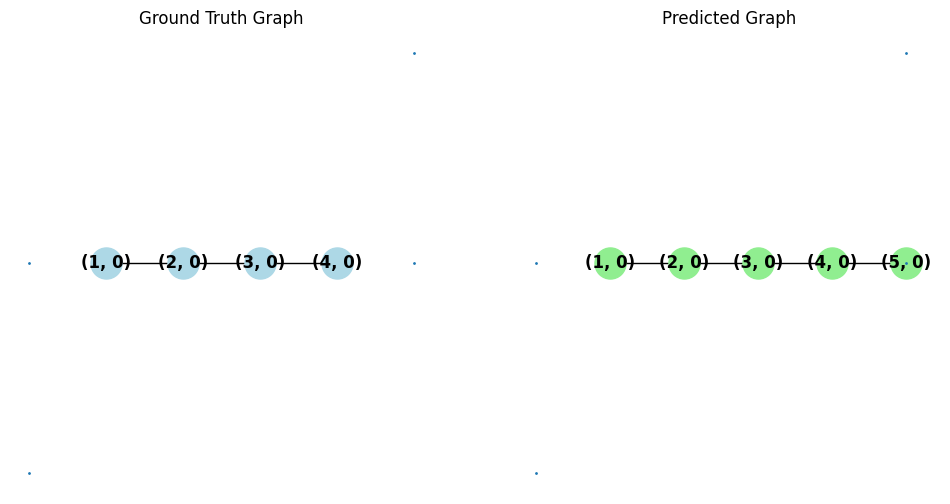

In [10]:
# Predicted Graph with a False Positive
predicted_graph = nx.Graph()
predicted_graph.add_nodes_from([(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)])                                 # Additional node (false positive +1)
predicted_graph.add_edges_from([((1, 0), (2, 0)), ((2, 0), (3, 0)), ((3, 0), (4, 0)), ((4, 0), (5, 0))]) # Incorrectly connected edge (false negatives +1)

print(TOPO(ground_truth_graph, predicted_graph))

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Ground Truth Graph
pos_ground_truth = {node: node for node in ground_truth_graph.nodes()}
nx.draw(ground_truth_graph, pos=pos_ground_truth, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold', ax=axes[0])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[0])
axes[0].set_title('Ground Truth Graph')

# Plot Predicted Graph
pos_predicted = {node: node for node in predicted_graph.nodes()}
nx.draw(predicted_graph, pos=pos_predicted, with_labels=True, node_size=500, node_color='lightgreen', font_weight='bold', ax=axes[1])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[1])
axes[1].set_title('Predicted Graph')

plt.show()

Precision
* TP=2 (nodes 1 and 2 in the ground truth graph have correct orientation in the predicted graph).
* FP=3 (nodes 4 and 5, and the edge between nodes 3 and 4 in the predicted graph are false positives).
* $P = \frac{2}{2 + 3} = \frac{2}{5} = 0.4$

Recall
* TP=2 (nodes 1 and 2 in the ground truth graph have correct orientation in the predicted graph).
* FN=2 (nodes 3 and 4 in the ground truth graph have no corresponding nodes in the predicted graph or incorrect orientation).
* $R = \frac{2}{2 + 2} = \frac{2}{4} = 0.5$

F1 Score
* The F1 score is the harmonic mean of precision and recall.
* $F1 = \frac{2 * 0.4 * 0.5}{0.4 + 0.5} = \frac{0.4}{0.9} = 0.4444$

In summary, the values (0.4, 0.5, 0.4444) indicate that the predicted graph has both false positives and false negatives.


 - The precision is 0.4, meaning that only 40% of the identified orientations in the predicted graph are correct.
 - The recall is 0.5, suggesting that 50% of the correct orientations in the ground truth graph are captured by the predicted graph.
 - The F1 score provides a balanced measure of precision and recall, yielding a value of approximately 0.4444.

(0.4, 0.5, 0.4444)


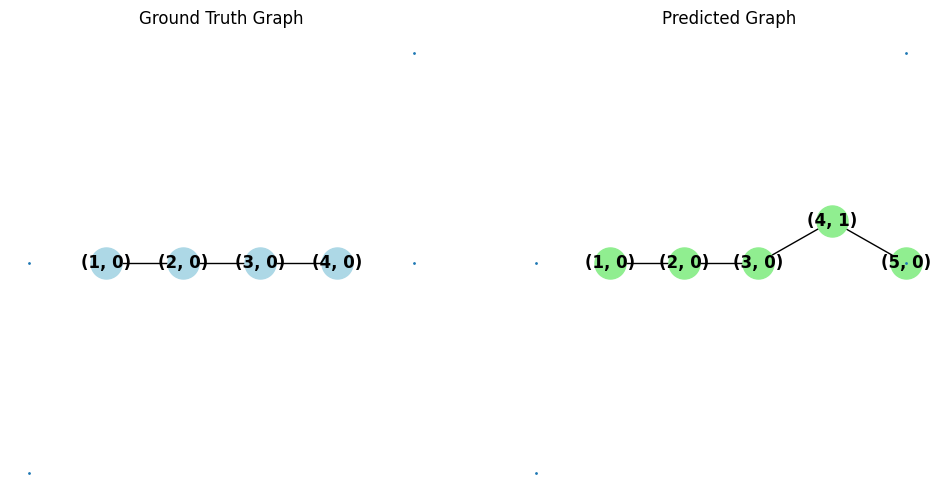

In [11]:
# Predicted Graph with a False Positive
predicted_graph = nx.Graph()
predicted_graph.add_nodes_from([(1, 0), (2, 0), (3, 0), (4, 1), (5, 0)])                                 # Incorrect node & Additional node (false positive +2)
predicted_graph.add_edges_from([((1, 0), (2, 0)), ((2, 0), (3, 0)), ((3, 0), (4, 1)), ((4, 1), (5, 0))]) # Incorrectly connected edge (false negative +2)

print(TOPO(ground_truth_graph, predicted_graph))

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Ground Truth Graph
pos_ground_truth = {node: node for node in ground_truth_graph.nodes()}
nx.draw(ground_truth_graph, pos=pos_ground_truth, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold', ax=axes[0])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[0])
axes[0].set_title('Ground Truth Graph')

# Plot Predicted Graph
pos_predicted = {node: node for node in predicted_graph.nodes()}
nx.draw(predicted_graph, pos=pos_predicted, with_labels=True, node_size=500, node_color='lightgreen', font_weight='bold', ax=axes[1])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[1])
axes[1].set_title('Predicted Graph')

plt.show()

(1.0, 1.0, 1.0)


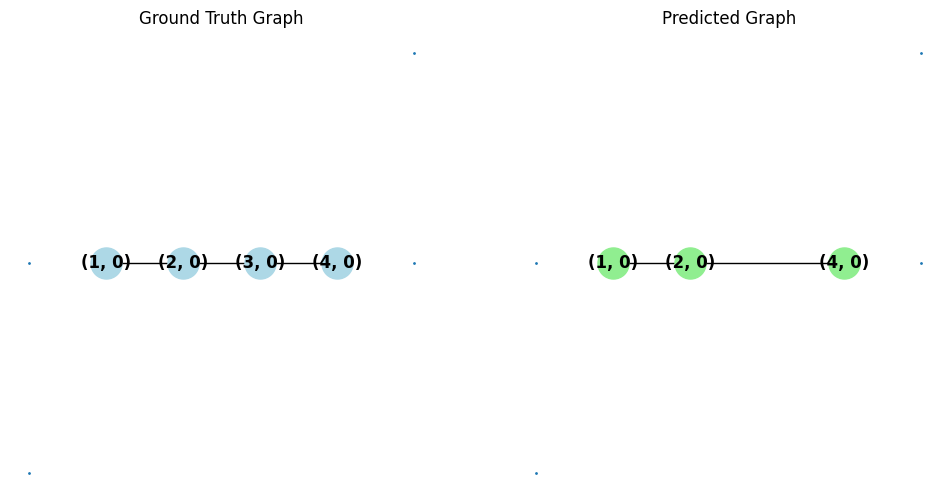

In [12]:
# Predicted Graph with a missing node (but the nearest node of (3, 0) is node (2, 0))
predicted_graph = nx.Graph()
predicted_graph.add_nodes_from([(1, 0), (2, 0), (4, 0)])             # Missing node
predicted_graph.add_edges_from([((1, 0), (2, 0)), ((2, 0), (4, 0))])

print(TOPO(ground_truth_graph, predicted_graph))

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Ground Truth Graph
pos_ground_truth = {node: node for node in ground_truth_graph.nodes()}
nx.draw(ground_truth_graph, pos=pos_ground_truth, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold', ax=axes[0])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[0])
axes[0].set_title('Ground Truth Graph')

# Plot Predicted Graph
pos_predicted = {node: node for node in predicted_graph.nodes()}
nx.draw(predicted_graph, pos=pos_predicted, with_labels=True, node_size=500, node_color='lightgreen', font_weight='bold', ax=axes[1])
nx.draw(G_box, pos=pos, node_size=1, ax=axes[1])
axes[1].set_title('Predicted Graph')

plt.show()